In [40]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
color_pal=sns.color_palette()

In [41]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [42]:
sales_b= df.drop(['Product Name','Product Category','Month','Market Size', 'Marketing Expense'],axis=1)

In [43]:
sales_b.head()

,Year,Sales,Month No.
Month-Year,,,
2019-01-01,2019,494357,1
2019-02-01,2019,837207,2
2019-03-01,2019,1278271,3
2019-04-01,2019,675985,4
2019-05-01,2019,757687,5


<Axes: title={'center': 'Product B'}, xlabel='Month-Year'>

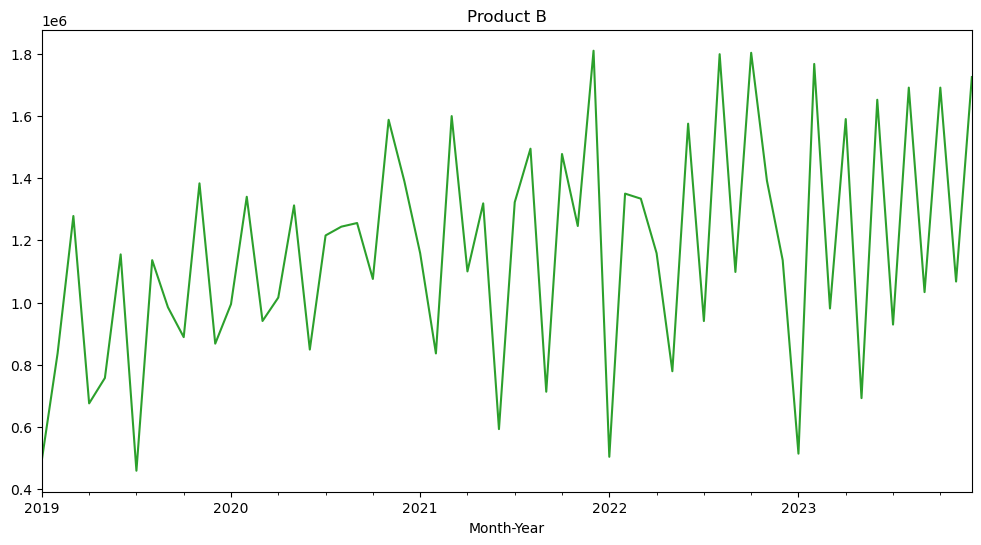

In [44]:
sales_b['Sales'].plot(figsize=(12,6),color=color_pal[2],title='Product B')

<Axes: ylabel='Frequency'>

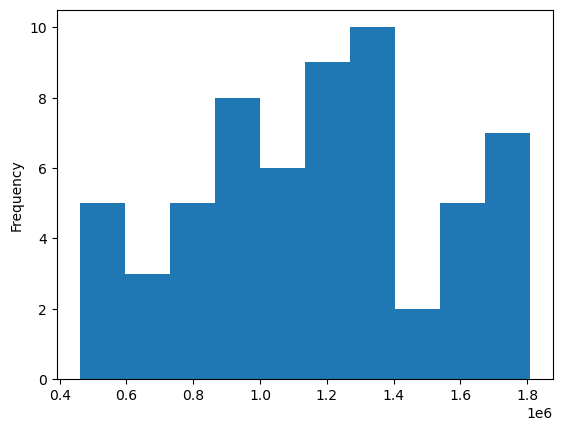

In [45]:
sales_b['Sales'].plot(kind='hist')

# Visualization

In [46]:
sales_b.head()

,Year,Sales,Month No.
Month-Year,,,
2019-01-01,2019,494357,1
2019-02-01,2019,837207,2
2019-03-01,2019,1278271,3
2019-04-01,2019,675985,4
2019-05-01,2019,757687,5


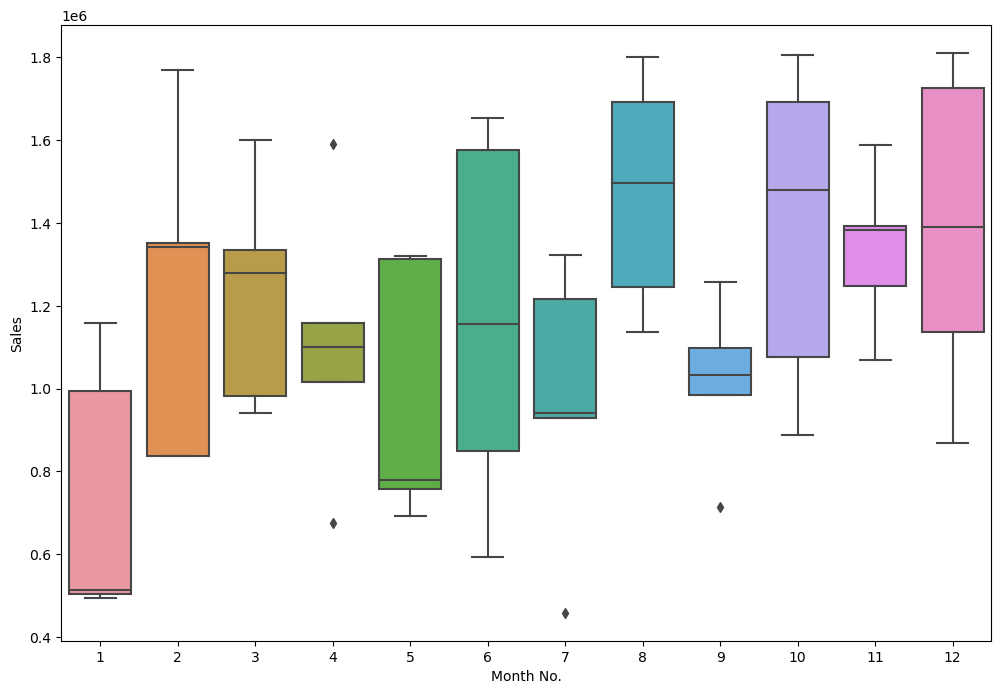

In [47]:
plt.figure(figsize=(12,8))
sns.boxplot(data=sales_b, x='Month No.',y='Sales')
plt.show()

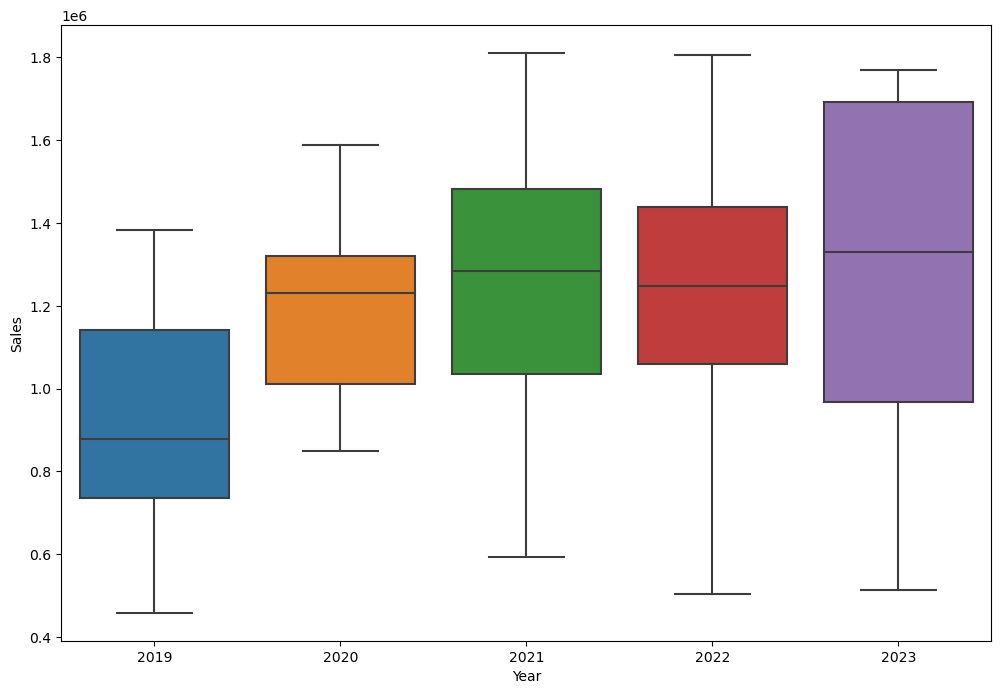

In [48]:
plt.figure(figsize=(12,8))
sns.boxplot(data=sales_b, x='Year',y='Sales')
plt.show()

# Feature Engineering

In [49]:
sales_b= df.drop(['Product Name','Product Category','Month','Market Size', 'Marketing Expense','Month No.','Year'],axis=1)

In [50]:
sales_b['quarter'] = sales_b.index.quarter
sales_b['month'] = sales_b.index.month
sales_b['year'] = sales_b.index.year

In [51]:
# Create lagged values
lagged_intervals = [3, 4, 5]  # Lagged intervals in months
for lag in lagged_intervals:
    sales_b[f'sales_lag_{lag}'] = sales_b['Sales'].shift(lag)

In [52]:

# Calculate moving averages with different window sizes
#window_sizes = [3, 6, 12]  # Example window sizes for quarterly, semi-annual, and annual seasonality

#for window_size in window_sizes:
    # Calculate moving average
#    sales_b[f'MA_{window_size}'] = sales_b['Sales'].rolling(window=window_size).mean()
#    sales_b[f'STD_{window_size}'] = sales_b['Sales'].rolling(window=window_size).std()
#    sales_b[f'CUMSUM_{window_size}'] = sales_b['Sales'].rolling(window=window_size).sum()

# Print the DataFrame with moving averages
print(sales_b)

              Sales  quarter  month  year  sales_lag_3  sales_lag_4  \
Month-Year                                                            
2019-01-01   494357        1      1  2019          NaN          NaN   
2019-02-01   837207        1      2  2019          NaN          NaN   
2019-03-01  1278271        1      3  2019          NaN          NaN   
2019-04-01   675985        2      4  2019     494357.0          NaN   
2019-05-01   757687        2      5  2019     837207.0     494357.0   
2019-06-01  1154891        2      6  2019    1278271.0     837207.0   
2019-07-01   459535        3      7  2019     675985.0    1278271.0   
2019-08-01  1136386        3      8  2019     757687.0     675985.0   
2019-09-01   984890        3      9  2019    1154891.0     757687.0   
2019-10-01   888942        4     10  2019     459535.0    1154891.0   
2019-11-01  1383258        4     11  2019    1136386.0     459535.0   
2019-12-01   867962        4     12  2019     984890.0    1136386.0   
2020-0

# Train/Test Split

In [53]:
train= sales_b[:57]
test=sales_b[57:]

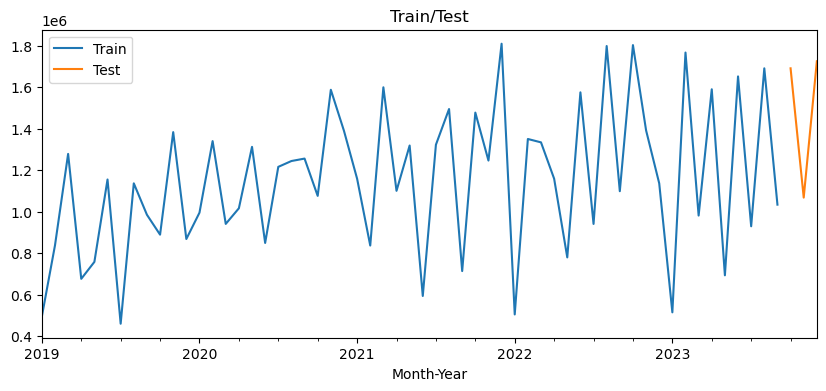

In [54]:
fig,ax=plt.subplots(figsize=(10,4))
train['Sales'].plot(ax=ax,label='Train set',title='Train/Test')
test['Sales'].plot(ax=ax,label='Test set')
plt.legend(['Train','Test'])
plt.show()

In [55]:
train.head()

,Sales,quarter,month,year,sales_lag_3,sales_lag_4,sales_lag_5
Month-Year,,,,,,,
2019-01-01,494357,1,1,2019,NaN,NaN,NaN
2019-02-01,837207,1,2,2019,NaN,NaN,NaN
2019-03-01,1278271,1,3,2019,NaN,NaN,NaN
2019-04-01,675985,2,4,2019,494357.0,NaN,NaN
2019-05-01,757687,2,5,2019,837207.0,494357.0,NaN


In [56]:
#x_train=train[['Month No.','Year','stationary_target','MA_3','MA_6','MA_12']]
#y_train=train['Sales']
#x_test=test[['Month No.','Year','stationary_target','MA_3','MA_6','MA_12']]
#y_test=test['Sales']

In [57]:
x_train = train.drop(columns=['Sales'])
y_train=train['Sales']
x_test=test.drop(columns=['Sales'])
y_test=test['Sales']

In [58]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000, 2000],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'subsample': [0.7, 0.8, 0.9, 1.0]
}

# Instantiate the XGBoost regressor
regressor = xgb.XGBRegressor(objective='reg:squarederror')

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Access the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters:", best_params)
print("Best estimator:", best_estimator)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
Best estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [59]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=3,
                       colsample_bytree=0.7,
                       subsample= 0.7,
                       early_stopping_rounds=50,
                       learning_rate=0.01)

reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1192780.44169	validation_1-rmse:1512076.99715
[100]	validation_0-rmse:527862.66579	validation_1-rmse:751600.06886
[200]	validation_0-rmse:280739.85252	validation_1-rmse:394040.75052
[300]	validation_0-rmse:185012.36511	validation_1-rmse:274263.40367
[400]	validation_0-rmse:140647.25087	validation_1-rmse:212531.08221
[500]	validation_0-rmse:114584.65059	validation_1-rmse:203960.34375
[501]	validation_0-rmse:114380.43940	validation_1-rmse:203708.04395


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
reg.best_iteration

451

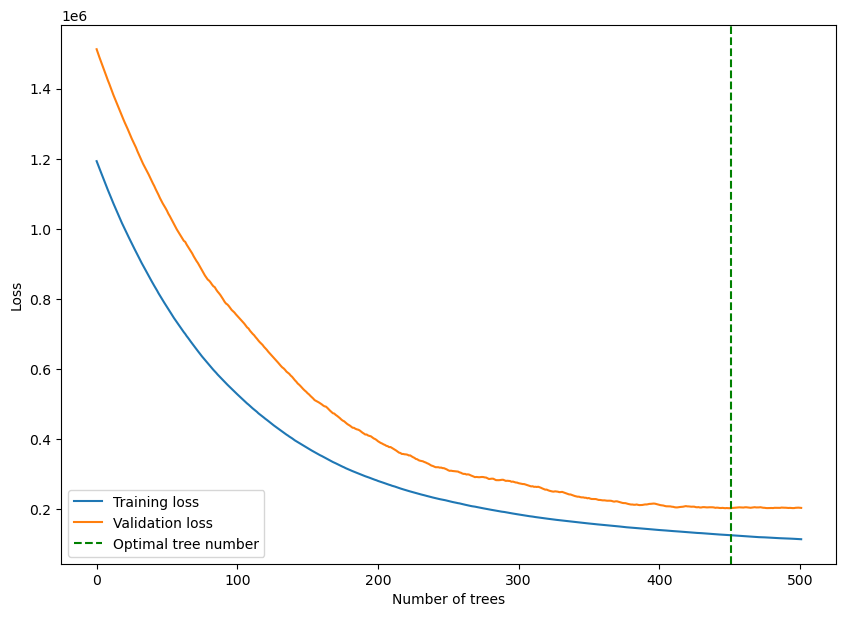

In [61]:
results = reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(451,color='green',ls='--', label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

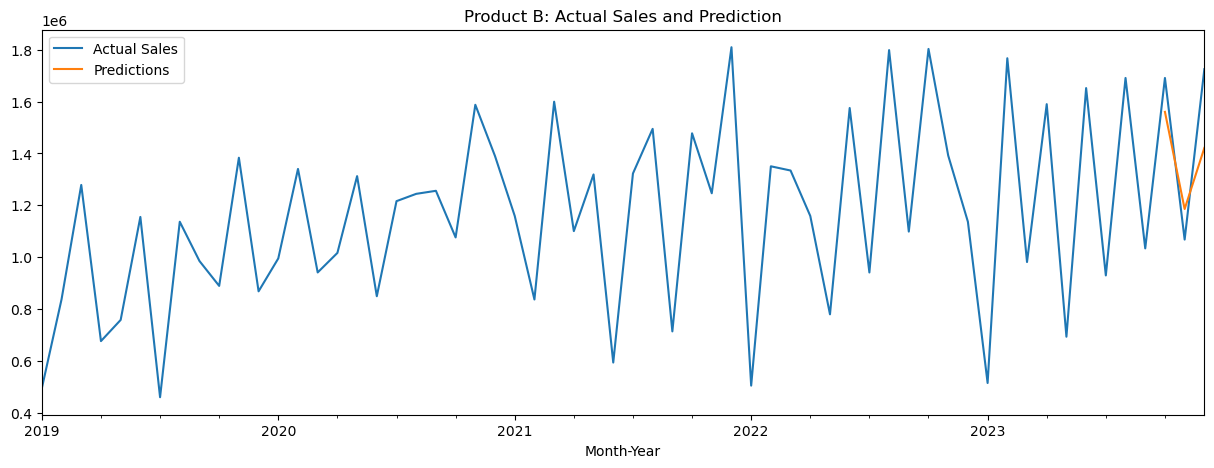

In [62]:
pred=reg.predict(x_test)
sales_b['prediction']=[None]*len(train) + list(pred)

ax = sales_b['Sales'].plot(figsize=(15, 5))
sales_b['prediction'].plot()
plt.legend(['Actual Sales', 'Predictions'])
ax.set_title('Product B: Actual Sales and Prediction')
plt.show()

In [63]:
mae_xgb= mean_absolute_error(test['Sales'],pred)
mse_xgb=mean_squared_error(test['Sales'], pred)
mape_xgb= mean_absolute_percentage_error(test['Sales'],pred)
rmse_xgb= np.sqrt(mean_squared_error(test['Sales'],pred))

print(f'MAE - XGBoost: {mae_xgb:0.3f}')
print(f'MAPE - XGBoost: {mape_xgb:0.3f}')
print(f'MSE - XGBoost: {mse_xgb:0.3f}')
print(f'RMSE - XGBoost: {rmse_xgb:0.3f}')

MAE - XGBoost: 184183.375
MAPE - XGBoost: 0.121
MSE - XGBoost: 41113841481.589
RMSE - XGBoost: 202765.484


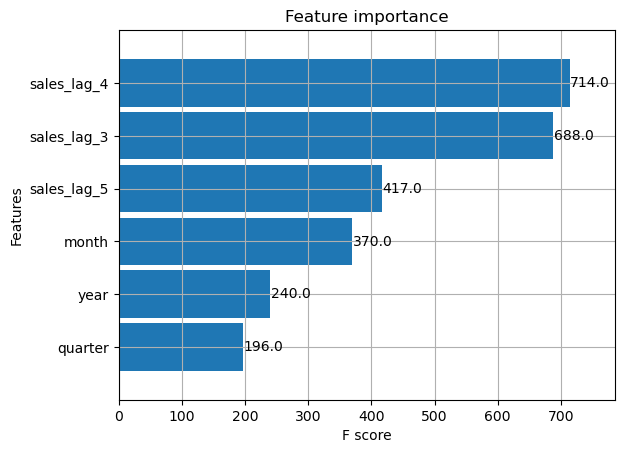

In [64]:
from xgboost import plot_importance

_ = plot_importance(reg, height=0.9)

# FORECASTING

In [65]:
x = sales_b.drop(columns=['Sales','prediction'])
y = sales_b['Sales']

In [66]:
reg_forecast= xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=3,
                       colsample_bytree=0.7,
                       subsample= 0.7,
                       learning_rate=0.01)
reg_forecast.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [67]:
future = pd.date_range(start='2024-01-01', end='2024-03-31', freq='MS')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
sales_b['isFuture'] = False
sales_b_and_future = pd.concat([sales_b, future_df])

In [68]:
sales_b_and_future['quarter'] = sales_b_and_future.index.quarter
sales_b_and_future['month'] = sales_b_and_future.index.month
sales_b_and_future['year'] = sales_b_and_future.index.year

In [69]:
# Create lagged values
lagged_intervals = [3,4,5]  # Lagged intervals in months
for lag in lagged_intervals:
    sales_b_and_future[f'sales_lag_{lag}'] = sales_b_and_future['Sales'].shift(lag)

In [71]:
sales_b_and_future.tail(20)

,Sales,quarter,month,year,sales_lag_3,sales_lag_4,sales_lag_5,prediction,isFuture
2022-08-01,1798441.0,3,8,2022,779318.0,1158736.0,1333941.0,NaN,False
2022-09-01,1098441.0,3,9,2022,1575105.0,779318.0,1158736.0,NaN,False
2022-10-01,1802885.0,4,10,2022,940648.0,1575105.0,779318.0,NaN,False
2022-11-01,1391774.0,4,11,2022,1798441.0,940648.0,1575105.0,NaN,False
2022-12-01,1136218.0,4,12,2022,1098441.0,1798441.0,940648.0,NaN,False
2023-01-01,514369.0,1,1,2023,1802885.0,1098441.0,1798441.0,NaN,False
2023-02-01,1767039.0,1,2,2023,1391774.0,1802885.0,1098441.0,NaN,False
2023-03-01,981026.0,1,3,2023,1136218.0,1391774.0,1802885.0,NaN,False
2023-04-01,1589911.0,2,4,2023,514369.0,1136218.0,1391774.0,NaN,False
2023-05-01,692905.0,2,5,2023,1767039.0,514369.0,1136218.0,NaN,False


In [72]:
sales_b_and_future=sales_b_and_future.drop(columns=['prediction'])

In [74]:
future_w_features = sales_b_and_future.query('isFuture').copy()
future_w_features=future_w_features.drop(columns=['Sales','isFuture'])

In [75]:
future_w_features

,quarter,month,year,sales_lag_3,sales_lag_4,sales_lag_5
2024-01-01,1,1,2024,1690948.0,1033615.0,1690948.0
2024-02-01,1,2,2024,1067615.0,1690948.0,1033615.0
2024-03-01,1,3,2024,1724948.0,1067615.0,1690948.0


In [76]:
future_w_features['pred'] = reg_forecast.predict(future_w_features)

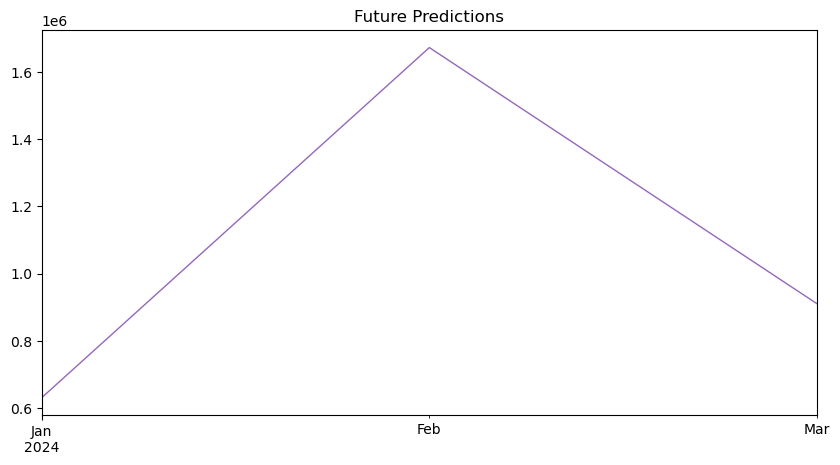

In [77]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

Text(0.5, 1.0, 'Product B')

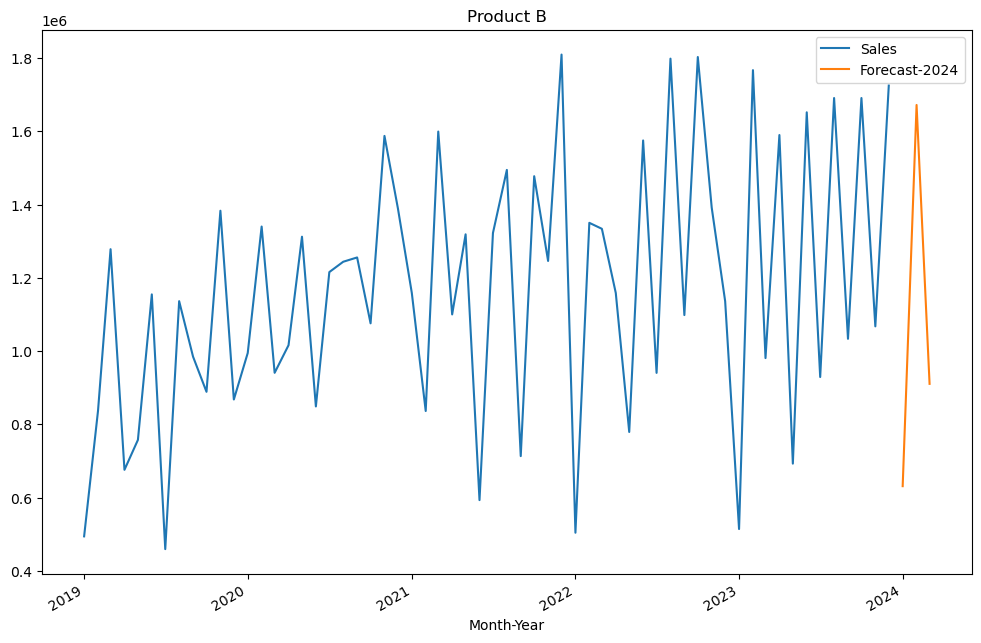

In [78]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
future_w_features['pred'].plot(legend=True, label='Forecast-2024')
plt.title('Product B')